# Reinforcement Learning and the Cartpole 

The cartpole is a control theory task where the goal is to balance a pole on a cart that sits on a one dimensional track.  You can push the cart left and right to balance the pole.

In this lecture we will use a neural network to learn a policy that tells us whether to push the cart left or right depending on the angle of the pole, the position of the cart, and the velocity of the cart.

We will train this neural network using reinforcement learning.  This is a technique where you have the agent (the neural network) run through the task over and over again, and update its policy (parameters of the neural network) based on its performance.

There are many algorithms that do reinforcement learning.  In this notebook we will use one called **policy gradient with baseline**.

This code comes from https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/blob/master/Chapter09/02_cartpole_reinforce.py

# Clones, Installs, Imports

## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [1]:
!git clone https://github.com/zlisto/reinforcement_learning_tutorial

import os
os.chdir("reinforcement_learning_tutorial")

Cloning into 'reinforcement_learning_tutorial'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 86 (delta 36), reused 68 (delta 18), pack-reused 0
Unpacking objects: 100% (86/86), done.


## Install Packages

In [2]:
%%time
!pip install pyvirtualdisplay ptan
!pip install gym[classic_control]
!apt-get install -y xvfb python-opengl ffmpeg 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.7 MB 4.7 kB/s 
  Created wheel for ptan: filename=ptan-0.7-py3-none-any.whl size=23503 sha256=20dc9047ea2e68aca2021cfd16c2d25184a44f0dc2ca578f9b9451978e31c5d5
  Stored in directory: /root/.cache/pip/wheels/60/72/3d/a3c47193fdb9efd08e3a54398af996b2989c68571813a71256
Successfully built ptan
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.7.0 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.7.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torc

## Import Librarires

There are three main libraries we will import.

1) `gym` - this has the simulation environment. 

2) `torch` - this does the neural network training.  

3) `ptan` - this has the agent wrapper we need to have the agent interact with the simulator.  

The other libraries help with visualizing the simulation.

In [3]:
from scripts.rl_helper import *
import gym
from IPython import display
from pyvirtualdisplay import Display
from matplotlib import animation

import ptan
import torch


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# Cartpole Environment
The name of the simulator environment is `"CartPole-v1"`, which we save to a variable `env_name`.  We can load the cart pole simulator environment with the `gym.make` function.  We use the `wrap_env` function so we can visualize the output of the simulator in Colab.

Note: You can load many different gym simulator environments with this line of code.  Just change `env_name`.  You can find a list of the gym environments here: https://www.gymlibrary.dev/

## Create Environment

In [4]:
env_name = "CartPole-v1"
#env_name = "MountainCar-v0"
env = gym.make(env_name,new_step_api=True)

query_environment(env_name)


Action Space: Discrete(2)
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Max Episode Steps: 500
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 475.0


## Visualize Environment

This code will run through the simulator and visualize it.  We use a random choice for the `action` of the agent.  The simulation stops when the pole tilts too far to the right or too far to the left. The score of the agent is the number of steps the simulation runs for, with a maximum value of 500.

The `show_video` function has the simulation loop.
Each time we run a step in the simulator,  we give an `action`, and the `env.step` function returns an `observation` of the state (pole angle, pole angular velocity, cart position, cart velocity), the current `reward` (it is 1 always), and a `done` variable that is `TRUE` if the pole tilted too far, or if we went 500 steps. 

We start the simulator by doing `env.reset()`, then use a `for` loop to run through the simulator one step at a time.  At the end we print out the score of the agent (how long it could balance the pole for), and we show a video of the agent balancing the pole on the cart.

CartPole-v1 score = 17.0


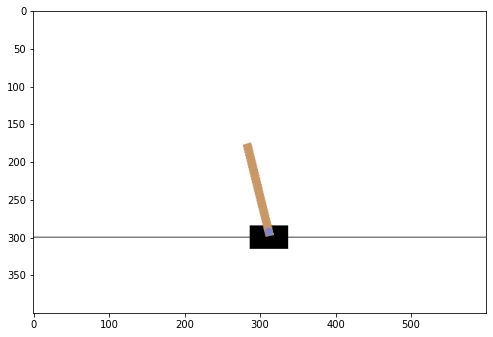

In [5]:
score = show_video(env)
print(f"{env_name} score = {score}")


# Neural Network for Actor and Critic

Because we are using policy gradient with a baseline, we need two neural networks:

1. Actor - this is the neural network of the agent playing cart pole.  This neural network takes as input the state and outputs a probability for each possible action

2. Critic - this is the neural network that measures the value of a given state.  The value is defined as the expected discounted reward if the game is played from this state under the given policy.  The critic network takes as input the state and outputs the value of the state.

We use the critic network as a baseline in the policy gradient equation.

## Create Neural Network for Actor
The `AN` class defines the actor network.  This is just a neural network for the policy.  To create the network, you specify the `input_size` and `output_size`.  The `input_size` is the size of the state and the `output_size` is the number of actions. 


We can pick how many neurons we went inside the network with the `num_neurons` variable.  We set it to 128 for now.  You can try adding more and see if it makes the agent perform better.

In [6]:
#Actor Network
class AN(nn.Module):
    def __init__(self, input_size, num_actions):
        super(AN, self).__init__()
        num_neurons = 128
        self.net = nn.Sequential(
            nn.Linear(input_size, num_neurons),
            nn.ReLU(),
            nn.Linear(num_neurons, num_actions)
        )

    def forward(self, x):
        return self.net(x)



## Create Neural Network for Critic

The `CN` class defines the critic network.  This is just a neural network for the value of a state.  To create the network, you specify the `input_size`.  The `input_size` is the size of the state.  

In [7]:
#Critic Network
class CN(nn.Module):
    def __init__(self, input_size):
        super(CN, self).__init__()
        num_neurons = 128
        self.net = nn.Sequential(
            nn.Linear(input_size, num_neurons),
            nn.ReLU(),
            nn.Linear(num_neurons, 1)
        )
    def forward(self, x):
        return self.net(x)

# Train Agent Using Policy Gradient with Baseline

## Initialize Learning Parameters
We set some parameters for the policy gradient algorithm.

1) `winning_score` = what score the agent needs to achieve to beat the simulator.

2) `GAMMA`   discount factor

3) `LEARNING_RATE` = gradient ascent step size

4) `EPISODES_TO_TRAIN` = number of episodes per batch when we do the gradient step

5) `filename_actor` = file where we will save the trained actor neural network.

6) `filename_critic` = file where we will save the trained critic neural network.


In [8]:
winning_score = 490     #cart pole
#winning_score = -110.0  #mountain car
GAMMA = 0.99
LEARNING_RATE = 0.01
EPISODES_TO_TRAIN = 4
filename_actor = f'{env_name}_actor'
filename_critic = f'{env_name}_critic'


## Initialize Some Other Stuff


1) `env` = the simulation environment.  We will use the `env_name` variable here  (you can change this to other environments if you want).

2) `net` = policy network  (neural network for the policy)

3) `agent` = an object that can play in the simulation and use the policy network to make actions.

4) `exp_source` = a generator that spits out a step of the simulator with the agent running the policy.

5) `optimizer` = the object that will do the gradient calculation and step for us.

In [9]:
env = gym.make(env_name)

num_actions = env.action_space.n
actor_net = AN(env.observation_space.shape[0], num_actions)  #actor network
critic_net = CN(env.observation_space.shape[0])  #critic network

agent = ptan.agent.PolicyAgent(actor_net, preprocessor=ptan.agent.float32_preprocessor,
                               apply_softmax=True)

optimizer = optim.Adam(actor_net.parameters(), lr=LEARNING_RATE)
optimizer_critic = optim.Adam(critic_net.parameters(), lr=LEARNING_RATE)

scores = []
step_idx = 0
done_episodes = 0

batch_episodes = 0
batch_states = [] 
batch_actions = [] 
batch_qvals = []
cur_rewards = []


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


## Train Agent with Policy Gradient with Baseline

This `for` loop will run policy gradient to train the agent.  It will print out the current score of the agent in the simulator, along with the average of the last 10 scores.  Hopefully we see the score increase as the agent learns to balance the pole.

In [10]:
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA)

for step_idx, exp in enumerate(exp_source):
    batch_states.append(exp.state)
    batch_actions.append(int(exp.action))
    cur_rewards.append(exp.reward)
    
  
    if exp.last_state is None:  #episode is done
        batch_qvals.extend(calc_qvals(cur_rewards,GAMMA))
        cur_rewards.clear()
        batch_episodes += 1


    # handle new rewards at end of episode
    new_rewards = exp_source.pop_total_rewards()
    if new_rewards:
        score = new_rewards[0]
        scores.append(score)
        mean_score = float(np.mean(scores[-10:]))
        if done_episodes%100==0: 
            print(f"Episode {done_episodes}, score: {score:.2f}, last 100 episodes avg score= {mean_score:.2f}")
        
        #condition when agent has "learned" to beat the simulator
        if mean_score >=winning_score:
            print(f"Solved in {done_episodes} episodes, {step_idx} steps!  Score = {mean_score:.1f}")
            torch.save(actor_net.state_dict(),filename_actor)
            break
        done_episodes += 1

    if batch_episodes < EPISODES_TO_TRAIN:
        continue

    optimizer.zero_grad()
    states_v = torch.FloatTensor(batch_states)
    batch_actions_t = torch.LongTensor(batch_actions)
    batch_qvals_v = torch.FloatTensor(batch_qvals)

    values_v = critic_net(states_v)  #calculate critic network value of each state in batch
    logits_v = actor_net(states_v)   #logits of each action according to actor network
    log_prob_v = F.log_softmax(logits_v, dim=1)
    advantage_v = (batch_qvals_v - values_v)
    log_prob_actions_v = advantage_v.detach() * log_prob_v[range(len(batch_states)), batch_actions_t]
    loss_v = -log_prob_actions_v.mean()
    loss_critic_v = advantage_v.pow(2).mean()

    loss_v.backward()  #take gradient
    loss_critic_v.backward()  #take gradient for critic

    optimizer.step()   #update actor paramters
    optimizer_critic.step()   #update critic paramters

    #clear out the batch after updating neural network
    batch_episodes = 0
    batch_states.clear()
    batch_actions.clear()
    batch_qvals.clear()
scores_pgb = scores

Episode 0, score: 21.00, last 100 episodes avg score= 21.00
Episode 100, score: 229.00, last 100 episodes avg score= 136.00
Episode 200, score: 500.00, last 100 episodes avg score= 465.10
Solved in 202 episodes, 36295 steps!  Score = 500.0


# Train agent with Policy Gradient

## Initialize Learning Parameters

We will use roughly the same parameters as policy gradient with baseline, but make a few changes.

In [11]:
filename_actor_pg  = f'{env_name}_actor_pg'

In [12]:
env = gym.make(env_name)

num_actions = env.action_space.n
net = AN(env.observation_space.shape[0], num_actions)

agent = ptan.agent.PolicyAgent(net, preprocessor=ptan.agent.float32_preprocessor,
                               apply_softmax=True)

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

scores = []
step_idx = 0
done_episodes = 0

batch_episodes = 0
batch_states = [] 
batch_actions = [] 
batch_qvals = []
cur_rewards = []


In [13]:
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA)

for step_idx, exp in enumerate(exp_source):
    batch_states.append(exp.state)
    batch_actions.append(int(exp.action))
    cur_rewards.append(exp.reward)
    
  
    if exp.last_state is None:  #episode is done
        batch_qvals.extend(calc_qvals(cur_rewards,GAMMA))
        cur_rewards.clear()
        batch_episodes += 1


    # handle new rewards
    new_rewards = exp_source.pop_total_rewards()
    if new_rewards:
        score = new_rewards[0]
        scores.append(score)
        mean_score = float(np.mean(scores[-10:]))
        if done_episodes%100==0: 
            print(f"Episode {done_episodes}, score: {score:.2f}, last 100 episodes avg score= {mean_score:.2f}")    
        
        #condition when agent has "learned" to beat the simulator
        if mean_score >=winning_score:
            print(f"Solved in {done_episodes} episodes, {step_idx} steps!  Score = {mean_score:.1f}")
            torch.save(net.state_dict(),filename_actor_pg)
            break
        done_episodes += 1

    if batch_episodes < EPISODES_TO_TRAIN:
        continue

    optimizer.zero_grad()
    states_v = torch.FloatTensor(batch_states)
    batch_actions_t = torch.LongTensor(batch_actions)
    batch_qvals_v = torch.FloatTensor(batch_qvals)

    logits_v = net(states_v)
    log_prob_v = F.log_softmax(logits_v, dim=1)
    log_prob_actions_v = batch_qvals_v * log_prob_v[range(len(batch_states)), batch_actions_t]
    loss_v = -log_prob_actions_v.mean()

    loss_v.backward()  #take gradient

    optimizer.step()   #update actor paramters

    #clear out the batch after updating neural network
    batch_episodes = 0
    batch_states.clear()
    batch_actions.clear()
    batch_qvals.clear()
scores_pg = scores

Episode 0, score: 15.00, last 100 episodes avg score= 15.00
Episode 100, score: 31.00, last 100 episodes avg score= 62.40
Episode 200, score: 112.00, last 100 episodes avg score= 183.50
Episode 300, score: 415.00, last 100 episodes avg score= 334.00
Solved in 312 episodes, 53812 steps!  Score = 496.0


# Plot Agent's Performance vs Episode
Plot the average score of the actor (how long it balanced the pole for) versus the training episode number for policy gradient and policy gradient with baseline.  We smooth the plots over multiple episodes to make a prettier plot.

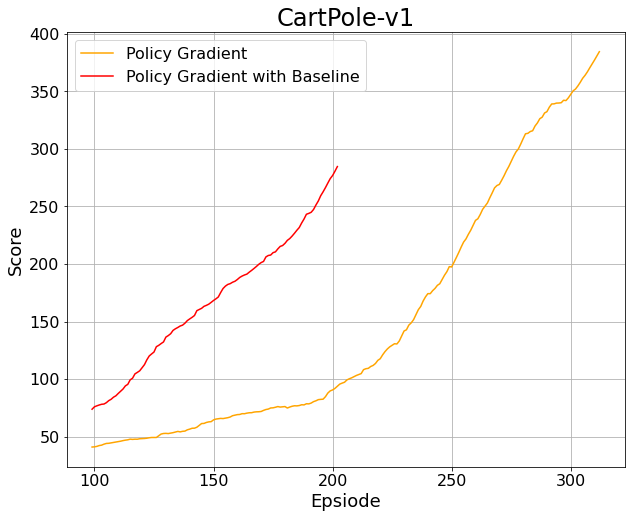

In [14]:
window = 100
df_pg = pd.DataFrame({'episode':[x for x in range(len(scores_pg))],
                   'score':scores_pg})
df_pg['score_smooth'] = df_pg.score.rolling(window=window).mean()
df_pgb = pd.DataFrame({'episode':[x for x in range(len(scores_pgb))],
                   'score':scores_pgb})
df_pgb['score_smooth'] = df_pgb.score.rolling(window=window).mean()

fig = plt.figure(figsize = (10,8))
sns.lineplot(data = df_pg, x = 'episode', y = 'score_smooth', color = 'orange', label='Policy Gradient')
sns.lineplot(data = df_pgb, x = 'episode', y = 'score_smooth', color = 'red', label='Policy Gradient with Baseline')
plt.legend(fontsize = 16)
plt.ylabel('Score',fontsize = 18)
plt.xlabel('Epsiode', fontsize = 18)
plt.title(f"{env_name}", fontsize = 24)
plt.grid()
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.show()



# Trained Agent Performance

## Load the Trained Agent
You can load the trained agent you saved.  Make sure you have the right filename.


In [15]:
#Load trained agent
net_trained = AN(env.observation_space.shape[0], env.action_space.n)
net_trained.load_state_dict(torch.load(filename_actor))
net_trained.eval()

agent_trained = ptan.agent.PolicyAgent(net_trained, preprocessor=ptan.agent.float32_preprocessor,
                               apply_softmax=True)


## Run Trained Agent in Enviornment
This cell lets you see how the trained agent performs.

CartPole-v1 with trained agent: score = 500.0


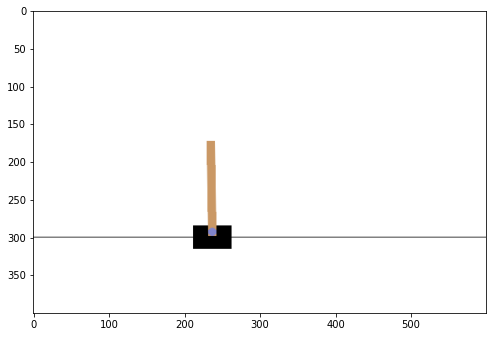

In [16]:
env = gym.make(env_name,new_step_api=True )
score = show_video(env, agent = agent_trained)
print(f"{env_name} with trained agent: score = {score}")
